In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
with open('../data/raw_data.json') as f:
    data = json.load(f)

In [3]:
# count values in bins
def bin_data(data, start, end, binsize):
    bins = np.zeros(int((end - start) / binsize) + 1)
    for timestamp in data:
        bins[int((timestamp - start) / binsize)] += 1
    return bins

We cut the data at 12:06 and 12:19:59 to adjust for the recordings starting/ending at slightly different timepoints.

In [4]:
def cut_data(data, cut_start, cut_end):
    return [timestamp for timestamp in data if timestamp >= cut_start and timestamp <= cut_end]

cut_start = 1734519960000 # 12:06
cut_end = 1734520799000 # 12:19:59
for spot in data["18. Dec (Wednesday)"]:
    if spot == "Metadata":
        continue
    data["18. Dec (Wednesday)"][spot] = cut_data(data["18. Dec (Wednesday)"][spot], cut_start, cut_end)

In [5]:
print(type(data))
data

<class 'dict'>


{'05. Dec (Thursday)': {'Metadata': {'Veggie': 'vegan currywurst with pommes',
   'Day_Menu': 'spicy asian sesame noodles',
   'Auswahl': 'vegetarian lasagna; potato vegetable pan',
   'Comment': 'Cash_T closed from 12:25; issues keeping track of many people moving simultanueously and queue wrapping around itself; sometimes people entering and leaving again (not deleted)',
   'Veggie & Cash': 'People queuing when food ran out; people taking too long at cash is major bottleneck; all going to Cash_L'},
  'Cash_T': [1733396115644,
   1733396120069,
   1733396120718,
   1733396121550,
   1733396124562,
   1733396127058,
   1733396134231,
   1733396150004,
   1733396156794,
   1733396202553,
   1733396235902,
   1733396242988,
   1733396258763,
   1733396260510,
   1733396266883,
   1733396276766,
   1733396285219,
   1733396329431,
   1733396335221,
   1733396383960,
   1733396398470,
   1733396402013,
   1733396405508,
   1733396419936,
   1733396456111,
   1733396459556,
   1733396499261

In [6]:
# plot that shows number of people passing through each spot in intervals with size of binsize
def plot_binned(data, date, spots, binsize):
    data = data[date]

    start = cut_start
    end = cut_end
    print(datetime.fromtimestamp(start / 1000.0).strftime('%H:%M:%S'))
    print(datetime.fromtimestamp(end / 1000.0).strftime('%H:%M:%S'))
    bin_num = int((end - start) / binsize) + 1 # same calculation as in bin_data
    x_labels = []
    for bin_i in range(0, bin_num):
        bin_start = start + bin_i * binsize
        x_labels.append(bin_start)

    for spot, timestamps in data.items():
        if spot not in spots:
            continue
        binned_data = bin_data(timestamps, start, end, binsize)
        plt.plot(x_labels, binned_data, label=spot)
    plt.xticks(x_labels, [datetime.fromtimestamp(ts / 1000.0).strftime('%H:%M:%S') for ts in x_labels], rotation=90)
    plt.legend()
    plt.ylabel('Number of people passing through')
    plt.xlabel('Time')
    plt.title('Number of people passing through every ' + str(binsize/1000) + ' s')

12:06:00
12:19:59


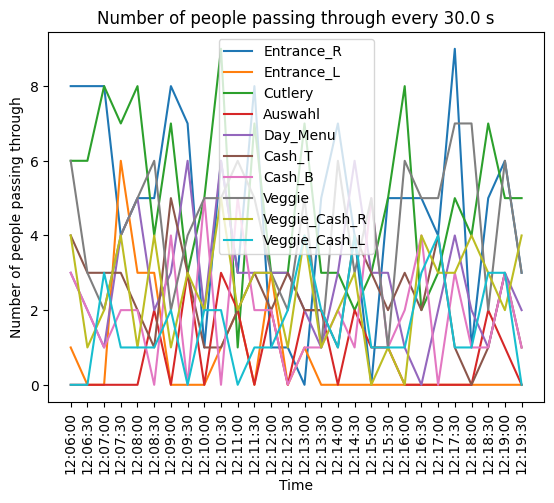

In [7]:
binsize = 30000 # ms = 60s = 1min
plot_binned(data, '18. Dec (Wednesday)', ['Entrance_R',
 'Entrance_L',
 'Cutlery',
 'Auswahl',
 'Day_Menu',
 'Cash_T',
 'Cash_B',
 'Veggie',
 'Veggie_Cash_R',
 'Veggie_Cash_L'], binsize)

Analysis is goind to continue with the 18. December data, because it was more balanced then and we were more trained in how to collect the data.

Now we want to calculate a correlation matrix of the different spots.

We choose 30s as a binsize to have an adequate number of people passing through.

In [8]:
d = data["18. Dec (Wednesday)"]
# all spots
spots = [
    "Entrance_R",
    "Entrance_L",
    "Cutlery",
    "Auswahl",
    "Day_Menu",
    "Cash_T",
    "Cash_B",
    "Veggie",
    "Veggie_Cash_R",
    "Veggie_Cash_L",
]
binsize = 30000 # ms = 30s

start = cut_start
end = cut_end
bin_num = int((end - start) / binsize) + 1 # same calculation as in bin_data
times = []
for bin_i in range(0, bin_num):
    bin_start = start + bin_i * binsize
    times.append(bin_start)

d_binned = {}
for spot, timestamps in d.items():
    if spot not in spots:
        continue
    binned_data = bin_data(timestamps, start, end, binsize)
    d_binned[spot] = binned_data

d_binned

{'Entrance_R': array([8., 8., 8., 4., 5., 5., 8., 7., 1., 6., 3., 8., 1., 1., 0., 5., 7.,
        4., 0., 5., 5., 5., 4., 9., 1., 5., 6., 3.]),
 'Entrance_L': array([1., 0., 0., 6., 3., 3., 0., 0., 0., 1., 2., 0., 3., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Cutlery': array([6., 6., 8., 7., 8., 4., 7., 3., 5., 9., 1., 7., 3., 3., 7., 3., 3.,
        2., 3., 5., 8., 2., 3., 5., 4., 7., 5., 5.]),
 'Auswahl': array([0., 0., 0., 0., 0., 2., 0., 3., 0., 3., 2., 0., 2., 0., 2., 2., 0.,
        2., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0.]),
 'Day_Menu': array([3., 2., 1., 4., 5., 2., 3., 6., 2., 6., 3., 3., 3., 3., 2., 1., 3.,
        6., 3., 3., 1., 0., 2., 4., 2., 1., 3., 2.]),
 'Cash_T': array([4., 3., 3., 3., 2., 1., 5., 3., 1., 1., 2., 3., 2., 3., 2., 2., 1.,
        4., 3., 2., 3., 2., 4., 1., 0., 1., 3., 1.]),
 'Cash_B': array([3., 2., 1., 2., 2., 0., 4., 0., 5., 0., 5., 2., 2., 0., 1., 1., 2.,
        1., 5., 1., 2., 4., 0., 3., 1., 1., 3., 1.]),
 'Veggie

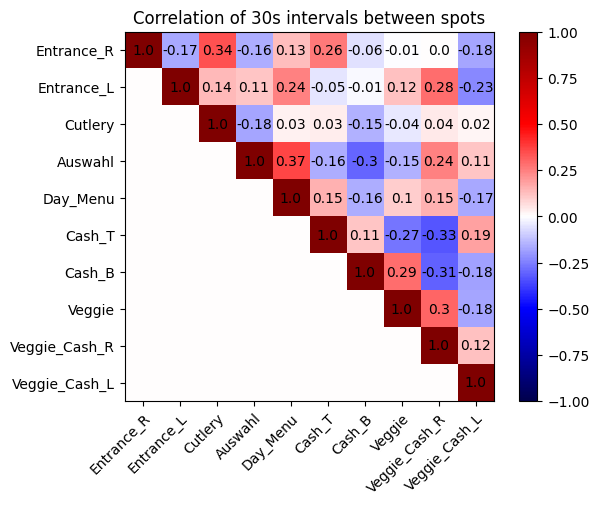

In [9]:
from matplotlib.colors import TwoSlopeNorm
# plot correlation matrix
labels = list(d_binned.keys())
m = np.triu(np.corrcoef(list(d_binned.values())), 0)

fig, ax = plt.subplots()
im = ax.imshow(m, norm = TwoSlopeNorm(0, vmin=-1, vmax=1), cmap="seismic")
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(labels)), labels=labels)

for i in range(len(labels)):
    for j in range(i, len(labels)):
        text = ax.text(j, i, round(m[i, j], 2), ha="center", va="center", color="black")

# show colorbar
fig.colorbar(im)

ax.set_title("Correlation of 30s intervals between spots")



plt.show()

If we limit our analysis to spots that are close to each other (because we have the correlation of the 30s intervals), we can see the following interesting correlations (TODO is this cherry-picking? Remember, it is not really about the results, rather about working correctly!):

- We can see that the correlation of Cutlery and Entrance_R is a little higher, and Entrance_L is also slightly positive.
- Correlation between Veggie and Veggie_Cash_R is a little higher, however with Veggie_Cash_L its slightly negative.
- Entrance_R does not really correlate with any food stations. Entrance_L has little higher postivive correlation with Day_Menu, and slightly positive with Auswahl and Veggie.
- Auswahl correlates with Veggie_Cash_R/L.
- Day_Menu correlates with Veggie_Cash_R and Cash_T.
- Veggie correlates with Cash_B.

Now lets take a look at the statistics for each spot.

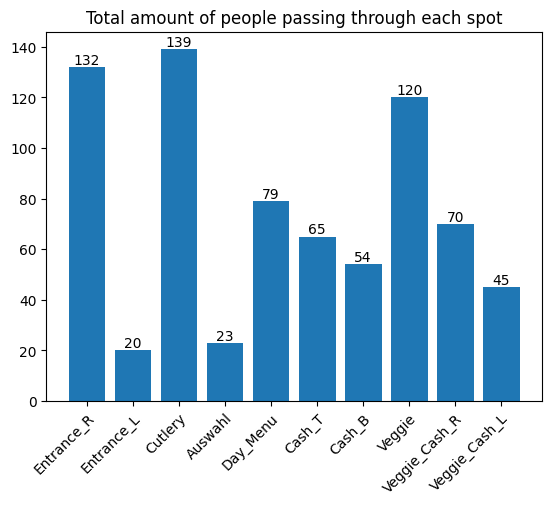

In [10]:
# Lets calculate the total amount of people
totals = []
for spot, bins in d_binned.items():
    totals.append(sum(bins))

fig, ax = plt.subplots()
ax.bar(labels, totals)
for i in range(len(labels)):
    ax.text(i, totals[i], int(totals[i]), ha="center", va="bottom", color="black")
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_title("Total amount of people passing through each spot")

plt.show()

Some interesting points (TODO: which have to be reconciled with the correlations however):

We can see that most people that enter go through Entrance_R (which is the entrance for Veggie and Auswahl). Only few people are going through Entrance_L (for the Day Menu). We can see that a lot more people are going to the Day_Menu than are entering in Entrance_L, so this is something to improve. When comparing the proportions of Veggie+Auswahl vs Day_Menu, we can see that this is different than the proportion of Entrance_R vs Entrance_L, further supporting our point.

We can also see that Veggie is more well-visited than Day_Menu and Auswahl together, which were both non-veggie on this day.

We can also see that Veggie_Cash_R+L together are roughly the amount of Veggie.

We can also see that Cash_B+T together are roughly the amount of Day_Menu+Auswahl.

Lets see the maximum timespan between people passing through for each spot.

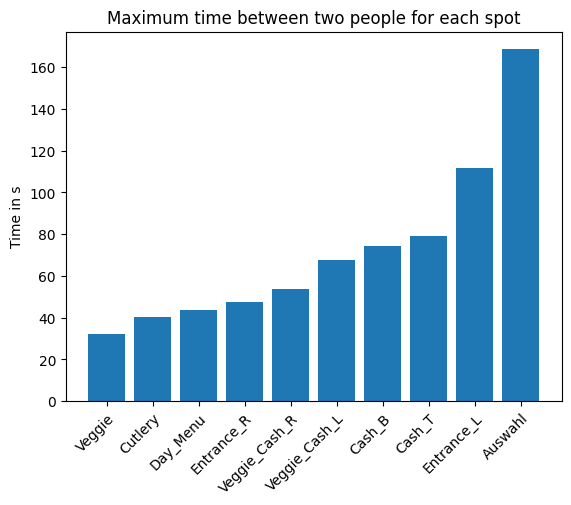

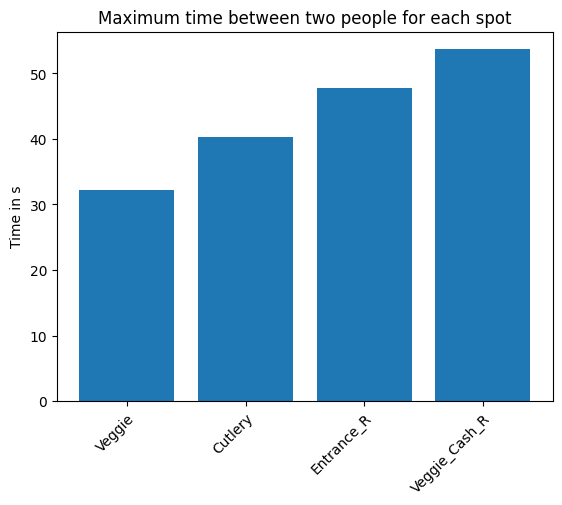

In [11]:
# get maximum timespan between two timestamps for each spot
max_diffs = {}
for spot, timestamps in d.items():
    if spot not in spots:
        continue
    max_diff = 0
    for i in range(1, len(timestamps)):
        diff = timestamps[i] - timestamps[i-1]
        if diff > max_diff:
            max_diff = diff
    max_diffs[spot] = max_diff

# sort max_diffs by value
max_diffs = dict(sorted(max_diffs.items(), key=lambda item: item[1], reverse=False))
labels = list(max_diffs.keys())

# max diffs are in ms, now we plot
fig, ax = plt.subplots()
ax.bar(labels, [diff / 1000 for diff in max_diffs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Maximum time between two people for each spot")

plt.show()

relevant_diffs = dict(filter(lambda x: x[0] in ["Veggie", "Cutlery", "Entrance_R", "Veggie_Cash_R"], max_diffs.items()))
labels = list(relevant_diffs.keys())
fig, ax = plt.subplots()
ax.bar(labels, [diff / 1000 for diff in relevant_diffs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Maximum time between two people for each spot")

plt.show()

The main problem with this plot is that we cannot differentiate whether a spot was empty for a long time, or whether a person took very long at a spot.

Assumptions:
- Veggie, Cutlery, Entrance_R, Veggie_Cash_R were always occupied.
- Day_Menu, Veggie_Cash_L, Cash_B, Cash_T, Entrance_L, Auswahl were sometimes empty.

By taking the always occupied spots as examples for the categories (food, cuttlery, entrance, and cash), which category is the biggest bottleneck? Rather than just looking at the maximum time spent, we should also take the average.

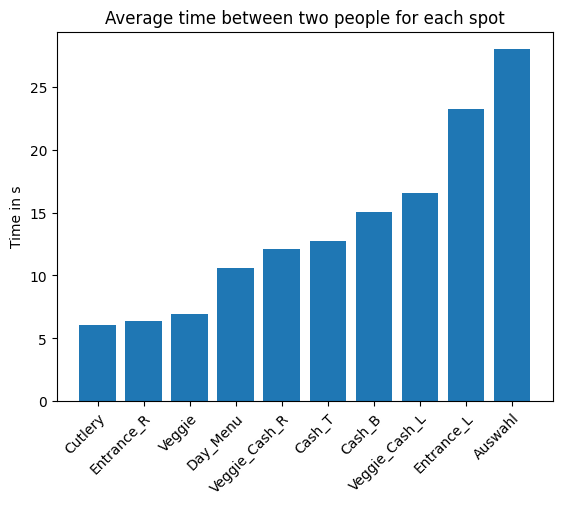

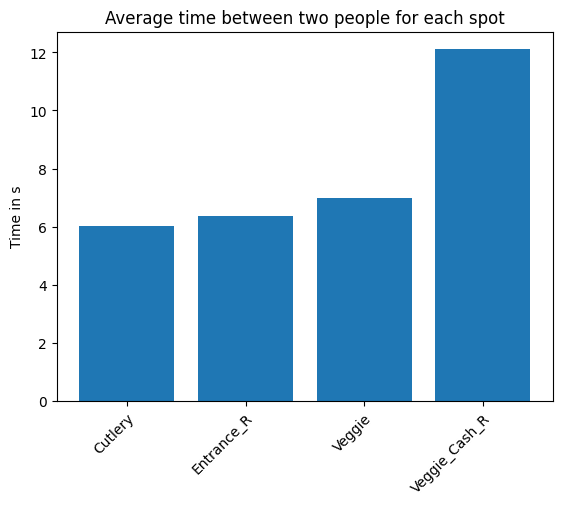

In [12]:
# look at average
avgs = {}
for spot, timestamps in d.items():
    if spot not in spots:
        continue
    diffs = []
    for i in range(1, len(timestamps)):
        diffs.append(timestamps[i] - timestamps[i-1])
    avgs[spot] = np.mean(diffs)

# sort avgs by value
avgs = dict(sorted(avgs.items(), key=lambda item: item[1], reverse=False))
labels = list(avgs.keys())

# avgs are in ms, now we plot
fig, ax = plt.subplots()
ax.bar(labels, [avg / 1000 for avg in avgs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Average time between two people for each spot")

plt.show()

relevant_avgs = dict(filter(lambda x: x[0] in ["Veggie", "Cutlery", "Entrance_R", "Veggie_Cash_R"], avgs.items()))
labels = list(relevant_avgs.keys())
fig, ax = plt.subplots()
ax.bar(labels, [avg / 1000 for avg in relevant_avgs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Average time between two people for each spot")

plt.show()

By looking at the always-occupied spots, we can see that people on average take the most time to pass through the cash.

# Markov Model

Idea: Get set of transition probabilities for each transition between time points. In other words, transition S1 -> S2 from t0 -> t1 by the observed data. Repeat this for all timepoints, and after each set, print the transition matrix (maybe some library to print it as a cool model?). We only consider certain transitions, though others are possible in theory. Smaller bins might be required because sometimes the speed is very fast (10s should be sufficient though, otherwise we get too sparse matrices).

As we basically generate many Markov Models (as represented by the Transition Matrix $M_i$), the probability is different from each Markov Model. To get a final model, get an estimated average for each probability (mean or median). 

We can also plot the change in probabilities over time, for example. 

The states and possible transitions include:
- S1: Cutlery -> S2, S3, self
- S2: Entrance_L -> S4, S5, S6, S7, self
- S3: Entrance_R -> S4, S5, S6, S7, self
- S4: Day_Menu -> S7, S8, S9, S10, self
- S5: Auswahl -> S7, S8, S9, S10, self
- S6: Veggie -> S7, S8, S9, S10, self
- S7: Day_Cash_T -> self
- S8: Day_Cash_B -> self
- S9: Veggie_Cash_L -> self
- S10: Veggie_Cash_R -> self

How to compute probabilities? Example: S1
- we restrict transitions to three for S1, which must logically sum up to 1
- $p(S_1->S_2) = S_{2,1} / S_{1,0} $
- $p(S_1->S_3) = S_{3,1} / S_{1,0}$
- $p(S_1->S_1) = 1 - (p(S_1->S_2) + p(S_1 -> S_3))$

- Problem: If S2_t1 + S3_t1 > S1_t0, system falls apart (which can happen due to miscounts!)
- Solution: Normalize to 1, in which case the probability to self ("queue") is also 0.

- to simplify code, create "guide matrix", which is the same size as transition matrix, but filled with strings indicating the nature of the transition
    - "None" = no transition between states: $p(S_x -> S_y) = 0$
    - "Pass" = normal transition between states: $p(S_x -> S_y) = S_{y,t} / S_{x,t-1}$
    - "Self" = transition to self or end state: $p(S_x -> S_y) = 1 - \Sigma_{i \in S} S_{i,t}$

Pseudocode:
For each bin $t=1,...,k$, create empty matrix $M_t$. For every cell/transition $M_t(x,y)$, do the following:
- if "None": $M_t(x,y) = 0$
- if "Pass": $M_t(x,y) = data(x,t) / data(y, t-1)$
- if "Queue": $M_t(x,y) = 1 - \Sigma_{i \in S} data(y, t)$. Crucially, this must always be the last step in each row, or last step in the entire matrix. Can fill with placeholder in first iterating, then fill in second one.

In [13]:
# dict_keys(['Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L'])
# must be in this exact order
print(spots)
guide_dict = {'Entrance_R':     ["Self", "None", "None", "Pass", "Pass", "None", "None", "Pass", "None", "None"],
              'Entrance_L':     ["None", "Self", "None", "Pass", "Pass", "None", "None", "Pass", "None", "None"],
              'Cutlery':        ["Pass", "Pass", "Self", "None", "None", "None", "None", "None", "None", "None"],
              'Auswahl':        ["None", "None", "None", "Self", "None", "Pass", "Pass", "None", "Pass", "Pass"],
              'Day_Menu':       ["None", "None", "None", "None", "Self", "Pass", "Pass", "None", "Pass", "Pass"],
              'Cash_T':         ["None", "None", "None", "None", "None", "Self", "None", "None", "None", "None"],
              'Cash_B':         ["None", "None", "None", "None", "None", "None", "Self", "None", "None", "None"],
              'Veggie':         ["None", "None", "None", "None", "None", "Pass", "Pass", "Self", "Pass", "Pass"],
              'Veggie_Cash_R':  ["None", "None", "None", "None", "None", "None", "None", "None", "Self", "None"],
              'Veggie_Cash_L':  ["None", "None", "None", "None", "None", "None", "None", "None", "None", "Self"]
}

['Entrance_R', 'Entrance_L', 'Cutlery', 'Auswahl', 'Day_Menu', 'Cash_T', 'Cash_B', 'Veggie', 'Veggie_Cash_R', 'Veggie_Cash_L']


In [14]:
# redefine bin size here
bin_num = int((end - start) / binsize) + 1 # same calculation as in bin_data
times = []
binsize = 15000
#for bin_i in range(0, bin_num):
#    bin_start = start + bin_i * binsize
#    times.append(bin_start)

d_binned = {}
for spot, timestamps in d.items():
    if spot not in spots:
        continue
    binned_data = bin_data(timestamps, start, end, binsize)
    d_binned[spot] = binned_data

d_binned

{'Entrance_R': array([4., 4., 6., 2., 2., 6., 2., 2., 5., 0., 3., 2., 8., 0., 4., 3., 0.,
        1., 3., 3., 3., 0., 0., 8., 1., 0., 0., 1., 0., 0., 4., 1., 3., 4.,
        0., 4., 0., 0., 3., 2., 1., 4., 1., 4., 2., 2., 6., 3., 0., 1., 3.,
        2., 2., 4., 0., 3.]),
 'Entrance_L': array([1., 0., 0., 0., 0., 0., 4., 2., 0., 3., 1., 2., 0., 0., 0., 0., 0.,
        0., 0., 1., 2., 0., 0., 0., 3., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]),
 'Cutlery': array([5., 1., 0., 6., 5., 3., 3., 4., 6., 2., 0., 4., 4., 3., 3., 0., 4.,
        1., 5., 4., 0., 1., 4., 3., 3., 0., 1., 2., 0., 7., 0., 3., 1., 2.,
        0., 2., 0., 3., 1., 4., 3., 5., 1., 1., 2., 1., 3., 2., 1., 3., 2.,
        5., 3., 2., 3., 2.]),
 'Auswahl': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0.,
        0., 2., 1., 2., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 2., 0., 0.,
        0., 2., 0., 1., 

In [15]:
models = []

# iterate over all times 1...n
for t in range(1, len(d_binned[spots[0]])):
    M = {}

    # for each row
    for i, spot in enumerate(spots):
        M[spot] = []
        n_from = d_binned[spot][t-1]
        # assign pass probabilities, or 0
        for j in range(10):
            n_to = d_binned[spots[j]][t]
            if guide_dict[spot][j] == "Pass":
                # prevent NaN
                if n_from == 0:
                    M[spot].append(0)
                else:
                    M[spot].append(n_to / n_from)
            else: 
                M[spot].append(0)
        # get sum over entire row
        sum_of_transitions = np.sum(M[spot])

        # if > 1 (due to miscounts etc.) -> normalize to 1
        if sum_of_transitions > 1:
            for j in range(10):
                if guide_dict[spot][j] == "Pass":
                    M[spot][j] = M[spot][j] / sum_of_transitions
        # if not, assign the self probability
        else:
            M[spot][i] = 1 - sum_of_transitions
    models.append(M)

print(models)

print(len(models))

[{'Entrance_R': [0.25, 0, 0, 0.0, 0.25, 0, 0, 0.5, 0, 0], 'Entrance_L': [0, 0, 0, 0.0, 0.3333333333333333, 0, 0, 0.6666666666666666, 0, 0], 'Cutlery': [0.8, 0.0, 0.19999999999999996, 0, 0, 0, 0, 0, 0, 0], 'Auswahl': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'Day_Menu': [0, 0, 0, 0, 0, 0.2857142857142857, 0.42857142857142855, 0, 0.2857142857142857, 0.0], 'Cash_T': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'Cash_B': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'Veggie': [0, 0, 0, 0, 0, 0.2857142857142857, 0.42857142857142855, 0, 0.2857142857142857, 0.0], 'Veggie_Cash_R': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'Veggie_Cash_L': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, {'Entrance_R': [0.75, 0, 0, 0.0, 0.0, 0, 0, 0.25, 0, 0], 'Entrance_L': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'Cutlery': [1.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0], 'Auswahl': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], 'Day_Menu': [0, 0, 0, 0, 0, 0.6666666666666666, 0.3333333333333333, 0, 0.0, 0.0], 'Cash_T': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 'Cash_B': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], 'Veggie': [0, 0,

In [16]:
# same stuff, but with matrices instead of dicts for easier handling
models = []

# iterate over all times 1...n
for t in range(1, len(d_binned[spots[0]])):
    M = np.zeros((10,10))

    # for each row
    for i, spot in enumerate(spots):
        n_from = d_binned[spot][t-1]
        # assign pass probabilities, or 0
        for j in range(10):
            n_to = d_binned[spots[j]][t]
            if guide_dict[spot][j] == "Pass":
                # prevent NaN
                if n_from == 0:
                    M[i][j] = 0
                else:
                    M[i][j] = n_to / n_from
            else: 
                M[i][j] = 0
        # get sum over entire row
        sum_of_transitions = np.sum(M[i])

        # if > 1 (due to miscounts etc.) -> normalize to 1
        if sum_of_transitions > 1:
            for j in range(10):
                if guide_dict[spot][j] == "Pass":
                    M[i][j] = M[i][j] / sum_of_transitions
        # if not, assign the self probability
        else:
            M[i][i] = 1 - sum_of_transitions
    models.append(M)

print(models)

print(len(models))

[array([[0.25      , 0.        , 0.        , 0.        , 0.25      ,
        0.        , 0.        , 0.5       , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.66666667, 0.        , 0.        ],
       [0.8       , 0.        , 0.2       , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.28571429, 0.42857143, 0.        , 0.28571429, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.      

In [17]:
# generate an average model, according to some metric
average_model = np.zeros((10,10))

for i in range(len(spots)):
    for j in range(len(spots)):
        transition_list = []
        for k in range(len(models)):
            transition_list.append(models[k][i][j])
        average_model[i][j] = np.mean(transition_list)
    # normalize row to 0
    transition_row_sum = np.sum(average_model[i])
    for j in range(len(spots)):
       average_model[i][j] = average_model[i][j] / transition_row_sum

print(average_model)


[[0.34757576 0.         0.         0.07257576 0.20867965 0.
  0.         0.37116883 0.         0.        ]
 [0.         0.82424242 0.         0.01818182 0.06575758 0.
  0.         0.09181818 0.         0.        ]
 [0.54251082 0.05939394 0.39809524 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.70909091 0.         0.07857143
  0.06896104 0.         0.07541126 0.06796537]
 [0.         0.         0.         0.         0.23181818 0.22445887
  0.175671   0.         0.22731602 0.14073593]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.24213564
  0.20961039 0.10636364 0.27226551 0.16962482]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.         

In [18]:
def pretty_print_matrix(M, labels):
    output = ""
    for i in range(len(M)):
        output = output + labels[i] + "\t"
        for j in range(len(M)):
            output = output + str(M[i][j]) + "\t"
        output = output + "\n"
    print(output)
    return output

pretty_print_matrix(average_model, spots)

#f = open("./average_model.tsv", "w")
#f.write(pretty_print_matrix(average_model, spots))
#f.close()



Entrance_R	0.3475757575757576	0.0	0.0	0.07257575757575756	0.2086796536796536	0.0	0.0	0.3711688311688312	0.0	0.0	
Entrance_L	0.0	0.8242424242424243	0.0	0.01818181818181818	0.06575757575757575	0.0	0.0	0.09181818181818181	0.0	0.0	
Cutlery	0.5425108225108225	0.059393939393939395	0.39809523809523817	0.0	0.0	0.0	0.0	0.0	0.0	0.0	
Auswahl	0.0	0.0	0.0	0.7090909090909091	0.0	0.07857142857142857	0.06896103896103896	0.0	0.07541125541125542	0.06796536796536796	
Day_Menu	0.0	0.0	0.0	0.0	0.23181818181818184	0.22445887445887447	0.1756709956709957	0.0	0.22731601731601733	0.14073593073593074	
Cash_T	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	0.0	
Cash_B	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	0.0	0.0	
Veggie	0.0	0.0	0.0	0.0	0.0	0.24213564213564215	0.20961038961038964	0.10636363636363635	0.2722655122655122	0.16962481962481965	
Veggie_Cash_R	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	0.0	
Veggie_Cash_L	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	1.0	



'Entrance_R\t0.3475757575757576\t0.0\t0.0\t0.07257575757575756\t0.2086796536796536\t0.0\t0.0\t0.3711688311688312\t0.0\t0.0\t\nEntrance_L\t0.0\t0.8242424242424243\t0.0\t0.01818181818181818\t0.06575757575757575\t0.0\t0.0\t0.09181818181818181\t0.0\t0.0\t\nCutlery\t0.5425108225108225\t0.059393939393939395\t0.39809523809523817\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t\nAuswahl\t0.0\t0.0\t0.0\t0.7090909090909091\t0.0\t0.07857142857142857\t0.06896103896103896\t0.0\t0.07541125541125542\t0.06796536796536796\t\nDay_Menu\t0.0\t0.0\t0.0\t0.0\t0.23181818181818184\t0.22445887445887447\t0.1756709956709957\t0.0\t0.22731601731601733\t0.14073593073593074\t\nCash_T\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0.0\t0.0\t0.0\t0.0\t\nCash_B\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0.0\t0.0\t0.0\t\nVeggie\t0.0\t0.0\t0.0\t0.0\t0.0\t0.24213564213564215\t0.20961038961038964\t0.10636363636363635\t0.2722655122655122\t0.16962481962481965\t\nVeggie_Cash_R\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t0.0\t1.0\t0.0\t\nVeggie_Cash_L\t0.0\t0.0\t0.0\t0

Everything below is written as functions and generally prefered

In [19]:
# as function this time, that returns all models
# note that start and end are basically global variables here

def get_models(d, spots, binsize, guide_dict):
    d_binned = {}
    for spot, timestamps in d.items():
        if spot not in spots:
            continue
        binned_data = bin_data(timestamps, start, end, binsize)
        d_binned[spot] = binned_data
    
    models = []

    # iterate over all times 1...n
    for t in range(1, len(d_binned[spots[0]])):
        M = np.zeros((len(spots),len(spots)))

        # for each row
        for i, spot in enumerate(spots):
            n_from = d_binned[spot][t-1]
            # assign pass probabilities, or 0
            for j in range(len(spots)):
                n_to = d_binned[spots[j]][t]
                if guide_dict[spot][j] == "Pass":
                    # prevent NaN
                    if n_from == 0:
                        M[i][j] = 0
                    else:
                        M[i][j] = n_to / n_from
                else: 
                    M[i][j] = 0
            # get sum over entire row
            sum_of_transitions = np.sum(M[i])

            # if > 1 (due to miscounts etc.) -> normalize to 1
            if sum_of_transitions > 1:
                for j in range(len(spots)):
                    if guide_dict[spot][j] == "Pass":
                        M[i][j] = M[i][j] / sum_of_transitions
            # if not, assign the self probability
            else:
                M[i][i] = 1 - sum_of_transitions
        models.append(M)
    return(models)




In [20]:
def get_average_model(models):
    print(type(models[0]))
    n = len(models[0])
    # generate an average model, according to some metric
    average_model = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            transition_list = []
            for k in range(len(models)):
                transition_list.append(models[k][i][j])
            average_model[i][j] = np.mean(transition_list)
        # normalize row to 0
        transition_row_sum = np.sum(average_model[i])
        for j in range(n):
            average_model[i][j] = average_model[i][j] / transition_row_sum
    return(average_model)

In [21]:
# new simplified model, only consider the following spots: Cutlery, Entrance_R, Veggie, Veggie_Cash_R
simple_spots = ["Cutlery", "Entrance_R", "Veggie", "Veggie_Cash_R"]
simple_spots_2 = ["Entrance_R", "Entrance_L", "Veggie", "Veggie_Cash_R"]

simple_guide_dict = {"Cutlery":         ["Self", "Pass", "None", "None"],
                     "Entrance_R":      ["None", "Self", "Pass", "None"],
                     "Veggie":          ["None", "None", "Self", "Pass"],
                     "Veggie_Cash_R":   ["None", "None", "None", "Self"]
}

simple_guide_dict_2 = {"Cutlery":         ["Self", "Pass", "Pass", "Pass"],
                       "Entrance_R":      ["None", "Self", "Pass", "Pass"],
                       "Veggie":          ["None", "None", "Self", "Pass"],
                       "Veggie_Cash_R":   ["None", "None", "None", "Self"]
}

simple_guide_dict_3 = {"Entrance_R":    ["Self", "None", "Pass", "None"],
                       "Entrance_L":    ["None", "Self", "Pass", "None"],
                       "Veggie":        ["None", "None", "Self", "Pass"],
                       "Veggie_Cash_R": ["None", "None", "None", "Self"],
}


# testing
simple_models_1 = get_models(d, ["Cutlery", "Entrance_R", "Veggie", "Veggie_Cash_R"], 30000, simple_guide_dict)
simple_models_2 = get_models(d, ["Cutlery", "Entrance_R", "Veggie", "Veggie_Cash_R"], 30000, simple_guide_dict_2)
simple_models_3 = get_models(d, simple_spots_2, 30000, simple_guide_dict_3)

print(simple_models_1[7])
print(simple_models_3[8])

# seperate function to get average model
#simple_model_1 = get_average_model(simple_models_1)
#simple_model_2 = get_average_model(simple_models_2)
#print(simple_model_1)
#print(simple_model_2)


# initial uniform distributions
initial_uniform_1 = [[0.5, 0.5, 0.0, 0.0],
                     [0.0, 0.5, 0.5, 0.0],
                     [0.0, 0.0, 0.5, 0.5],
                     [0.0, 0.0, 0.0, 1.0]
                     ]

initial_uniform_2 = [[0.25, 0.25, 0.25, 0.25],
                     [0.0, 1/3, 1/3, 1/3],
                     [0.0, 0.0, 0.5, 0.5],
                     [0.0, 0.0, 0.0, 1.0]
                     ]

[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.28571429 0.71428571 0.        ]
 [0.         0.         0.5        0.5       ]
 [0.         0.         0.         1.        ]]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [22]:
get_average_model(simple_models_2)

<class 'numpy.ndarray'>


array([[0.        , 0.3916019 , 0.39025791, 0.21814019],
       [0.        , 0.14510582, 0.55255197, 0.30234221],
       [0.        , 0.        , 0.45123457, 0.54876543],
       [0.        , 0.        , 0.        , 1.        ]])

In [23]:
# simulate
def simulate_markov(initial_dist, models):
    final_dist = initial_dist
    for model in models:
        final_dist = np.dot(final_dist, model)
    return final_dist
        
#simulate_markov(initial_uniform_1, simple_models_1)
simulate_markov(initial_uniform_2, simple_models_2)


# question: how to simulate? intuitively this requires a prior distribution (easy assumption), and some matrices to simulate (multiply with np.dot(matrix 1, matrix 2))
# idea: assume initial uniform dist, then multiply by my own calculated matrices in each step. Check how the result looks like, and come up with some metric
# the initial assumption might be entirely uniform OR only consider the possible passing, as described in their specific matrices
# when done, simulate n times, set up metric as described in tutor mail

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [24]:
# only works for four spots right now
def markov_metric(A, n, s0):
    s_exit = [0,0,0,1]
    M = A
    for i in range(n):
        M = np.dot(M, A)
    result = np.subtract(np.dot(M, s0), s_exit)
    return(np.linalg.norm(result))

s0 = [1, 0, 0, 0]

#markov_metric(simple_models_3[2], 30, s0)
markov_metric(simple_models_1[5], 2, s0)



1.0

In [25]:
markov_metric(get_average_model(simple_models_1), 2, s0)

<class 'numpy.ndarray'>


1.0003437344878392

 ||$A^n \cdot s_0 - \text{[0,0,0,1]}$ ||

 - transition matrix $A^n$
 - simulated $n$ times
 - $s_0$ a array with |spots| entries, with positives values $\Sigma = 1$ for entries 

# Markov: regression approach
- instead of discretely computing probabilities in each step, try to use a regression model
- basically for each step, consider column of peoples in each spot at $t$ vs column of people in each spot at $t + 1$
    - problem: this gets a lot of linear regressors, for every step
    - idea: as we probably require a vector vs vector thingy, with features and classes, use time stamp as vector $b$
    - idea: better: for each transition S1 -> S2, get vector of people in S1 vs vector of people in S2. Somehow compute a transition probability from that. 
- individual regression for each spot, at least I think thats the thing
- need some more time to think about it
- problem: how to get to a transition matrix from there?

In [26]:
from sklearn import linear_model
rgr = linear_model.LinearRegression()

# s1[t0, t1, t2, t3] vs s2[t1, t2, t3t, t4] -> value for s1, s2 
# that value can probably be normalize to some value?
# seriously I think thats useless, that doesn't take half the info into account

simple t0[s1,s2,s3,s4] vs t1[s1,s2,s3,s4], will that maybe reveal the shift? probably should, at least the x value, right?

In [27]:
def get_shifted_pops(spots, t):
    l0 = []
    l1 = []
    for i, crt_spot in enumerate(spots):
        print(crt_spot)
        l0.append(d_binned[crt_spot][t])
        l1.append(d_binned[crt_spot][t+1])
    l0 = np.array(l0).reshape(-1,1)
    l1 = np.array(l1).reshape(-1,1)
    return l0,l1

In [28]:
# get vectors for each time point, probably from binned data
#d_binned

t0, t1 = get_shifted_pops(["Cutlery", "Entrance_R", "Veggie", "Veggie_Cash_R"], 0)
rgr.fit(t0, t1)
print(rgr.coef_)

Cutlery
Entrance_R
Veggie
Veggie_Cash_R
[[-0.15789474]]


Trying: spot vs spot, no shift

In [29]:
cutlery = np.array(d_binned["Cutlery"]).reshape(-1,1)
entrance = np.array(d_binned["Entrance_R"]).reshape(-1,1)
veggie = np.array(d_binned["Veggie"]).reshape(-1,1)
veggie_cash = np.array(d_binned["Veggie_Cash_R"]).reshape(-1,1)
linear_model.LinearRegression().fit(entrance, veggie).coef_

array([[-0.03403465]])

Honestly I'm not too sure with anything I've tested, transforming different regressions into transitions is fairly unintuitive, I'd tried to get a simple model running instead

# Hopefully final approach (simple computation, model comparison)

- we just use the transition matrix gained from observations in each spot, not from the regression
- we can use the model to simulate where people go from each spot (input: matrix of people in s1...), by multiplying the matrix n times (n = 30s)
- we can use that to show that if we were to somehow change a transition probability, then more people would end up sooner in one of the end states

only question: which model should we use? probably one in the very busy time periods, and then a model that uses some split states? (like using both entrances)
- use a model that assumes only direct paths, sums up all cashiers and food respectively
- or for now, use the simple model that has realistic queue transitions and try with 100 people each, then reduce queue times in one spot and test again




In [30]:
def simulate_markov_2(initial_pop, transition_matrix, n=1, type="simple"):
    crt_pop = initial_pop
    for i in range(n):
        # if only one transition matrix is given
        if type == "simple":
            crt_pop = np.dot(crt_pop, transition_matrix)
        # if list of matrices is given (simulate over time)
        else: 
            crt_pop = np.dot(crt_pop, transition_matrix[i])
    print(crt_pop)
    return crt_pop

In [31]:
initial = [100, 0, 0, 0]
transition_matrix = get_average_model(simple_models_2)
print(transition_matrix)

theoretical_model = np.array([[0, 0.2, 0.6,  0.2],
                              [0, 0.1, 0.65, 0.25],
                              [0, 0,   0.3,  0.7],
                              [0, 0,   0,    1]
])
print(theoretical_model)

<class 'numpy.ndarray'>
[[0.         0.3916019  0.39025791 0.21814019]
 [0.         0.14510582 0.55255197 0.30234221]
 [0.         0.         0.45123457 0.54876543]
 [0.         0.         0.         1.        ]]
[[0.   0.2  0.6  0.2 ]
 [0.   0.1  0.65 0.25]
 [0.   0.   0.3  0.7 ]
 [0.   0.   0.   1.  ]]


In [32]:
simulate_markov_2(initial, transition_matrix, n=4, type="simple")
simulate_markov_2(initial, theoretical_model, n=4, type="simple")

[ 0.          0.1196463   9.86374624 90.01660746]
[0.000e+00 2.000e-02 3.310e+00 9.667e+01]


array([0.000e+00, 2.000e-02, 3.310e+00, 9.667e+01])